In [1]:
import random, numpy, math, gym, scipy
import matplotlib.pyplot as plt
from SumTree import SumTree

In [2]:
IMAGE_WIDTH = 84
IMAGE_HEIGHT = 84
IMAGE_STACK = 2

HUBER_LOSS_DELTA = 2.0
LEARNING_RATE = 0.00025

## Utils

In [3]:
def huber_loss(y_true, y_pred):
    err = y_true - y_pred

    cond = K.abs(err) < HUBER_LOSS_DELTA
    L2 = 0.5 * K.square(err)
    L1 = HUBER_LOSS_DELTA * (K.abs(err) - 0.5 * HUBER_LOSS_DELTA)

    loss = tf.where(cond, L2, L1)   # Keras does not cover where function in tensorflow :-(

    return K.mean(loss)

def processImage( img ):
    rgb = scipy.misc.imresize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), interp='bilinear')

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b     # extract luminance

    o = gray.astype('float32') / 128 - 1    # normalize
    return o

## This is a level 2 heading

In [4]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.models import Sequential, load_model, model_from_yaml

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

In [5]:
class Brain:
    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.model = self._createModel()
        self.model_ = self._createModel()  # target network

    def _createModel(self):
        model = Sequential()

        model.add(Conv2D(32, (8, 8), strides=(4,4), activation='relu', input_shape=(self.stateCnt), data_format='channels_first'))
        model.add(Conv2D(64, (4, 4), strides=(2,2), activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(units=512, activation='relu'))

        model.add(Dense(units=actionCnt, activation='linear'))

        opt = RMSprop(lr=LEARNING_RATE)
        model.compile(loss=huber_loss, optimizer=opt)

        return model

    def train(self, x, y, epochs=1, verbose=0):
        self.model.fit(x, y, batch_size=32, epochs=epochs, verbose=verbose)

    def predict(self, s, target=False):
        if target:
            return self.model_.predict(s)
        else:
            return self.model.predict(s)

    def predictOne(self, s, target=False):
        return self.predict(s.reshape(1, IMAGE_STACK, IMAGE_WIDTH, IMAGE_HEIGHT), target).flatten()

    def updateTargetModel(self):
        self.model_.set_weights(self.model.get_weights())

## Memory

In [6]:
class Memory:   # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.6

    def __init__(self, capacity):
        self.tree = SumTree(capacity)

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._getPriority(error)
        self.tree.add(p, sample) 

    def sample(self, n):
        batch = []
        segment = self.tree.total() / n

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        p = self._getPriority(error)
        self.tree.update(idx, p)

## Agent

In [7]:
MEMORY_CAPACITY = 200000

BATCH_SIZE = 32

GAMMA = 0.99

MAX_EPSILON = 1
MIN_EPSILON = 0.1

EXPLORATION_STOP = 5   # at this step epsilon will be 0.01
LAMBDA = - math.log(0.01) / EXPLORATION_STOP  # speed of decay

UPDATE_TARGET_FREQUENCY = 10000

class Agent:
    steps = 0
    epsilon = MAX_EPSILON

    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.brain = Brain(stateCnt, actionCnt)
        # self.memory = Memory(MEMORY_CAPACITY)
        
    def act(self, s):
        if random.random() < self.epsilon:
            return random.randint(0, self.actionCnt-1)
        else:
            return numpy.argmax(self.brain.predictOne(s))

    def observe(self, sample):  # in (s, a, r, s_) format
        x, y, errors = self._getTargets([(0, sample)])
        self.memory.add(errors[0], sample)

        if self.steps % UPDATE_TARGET_FREQUENCY == 0:
            self.brain.updateTargetModel()

        # slowly decrease Epsilon based on our eperience
        self.steps += 1
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)

    def _getTargets(self, batch):
        no_state = numpy.zeros(self.stateCnt)

        states = numpy.array([ o[1][0] for o in batch ])
        states_ = numpy.array([ (no_state if o[1][3] is None else o[1][3]) for o in batch ])

        p = agent.brain.predict(states)

        p_ = agent.brain.predict(states_, target=False)
        pTarget_ = agent.brain.predict(states_, target=True)

        x = numpy.zeros((len(batch), IMAGE_STACK, IMAGE_WIDTH, IMAGE_HEIGHT))
        y = numpy.zeros((len(batch), self.actionCnt))
        errors = numpy.zeros(len(batch))
        
        for i in range(len(batch)):
            o = batch[i][1]
            s = o[0]; a = o[1]; r = o[2]; s_ = o[3]
            
            t = p[i]
            oldVal = t[a]
            if s_ is None:
                t[a] = r
            else:
                t[a] = r + GAMMA * pTarget_[i][ numpy.argmax(p_[i]) ]  # double DQN

            x[i] = s
            y[i] = t
            errors[i] = abs(oldVal - t[a])

        return (x, y, errors)

    def replay(self):    
        batch = self.memory.sample(BATCH_SIZE)
        x, y, errors = self._getTargets(batch)

        #update errors
        for i in range(len(batch)):
            idx = batch[i][0]
            self.memory.update(idx, errors[i])

        self.brain.train(x, y)

class RandomAgent:
    memory = Memory(MEMORY_CAPACITY)
    exp = 0

    def __init__(self, actionCnt):
        self.actionCnt = actionCnt

    def act(self, s):
        return random.randint(0, self.actionCnt-1)

    def observe(self, sample):  # in (s, a, r, s_) format
        error = abs(sample[2])  # reward
        self.memory.add(error, sample)
        self.exp += 1

    def replay(self):
        pass

## ENVIRONMENT

In [8]:
class Environment:
    def __init__(self, problem):
        self.problem = problem
        self.env = gym.make(problem)

    def run(self, agent):                
        img = self.env.reset()
        w = processImage(img)
        s = numpy.array([w, w])
        
        R = 0
        
        while True:         
            # self.env.render()
            a = agent.act(s)

            r = 0
            img, r, done, info = self.env.step(a)
            s_ = numpy.array([s[1], processImage(img)]) #last two screens

            r = np.clip(r, -1, 1)   # clip reward to [-1, 1]

            if done: # terminal state
                s_ = None

            agent.observe( (s, a, r, s_) )
            agent.replay()            

            s = s_
            R += r

            if done:
                break
#         print("Total reward:", R)
        return R

## Main

In [9]:
PROBLEM = 'Seaquest-v0'
env = Environment(PROBLEM)

stateCnt  = (IMAGE_STACK, IMAGE_WIDTH, IMAGE_HEIGHT)
actionCnt = env.env.action_space.n

agent = Agent(stateCnt, actionCnt)
randomAgent = RandomAgent(actionCnt)

Rewards = []
Time_steps = []

max_timesteps = 200

try:
    print("Initialization with random agent...")
    while randomAgent.exp < MEMORY_CAPACITY:
        env.run(randomAgent)
        #print(randomAgent.exp, "/", MEMORY_CAPACITY)

    agent.memory = randomAgent.memory

    randomAgent = None

    print("Starting learning")
    
    for t in range(max_timesteps):
#     while True:
        R = env.run(agent)
        print("Time step {}, Reward {}".format((t + 1), R))
        
        Time_steps.append(t + 1)
        Rewards.append(R)
        
finally:
    print("done...")
#     agent.brain.model.save("Seaquest-DQN-PER.h5")

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Initialization with random agent...


/usr/lib/python3/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/lib/python3/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Starting learning
Time step 1, Reward 9.0
Time step 2, Reward 11.0
Time step 3, Reward 5.0
Time step 4, Reward 5.0
Time step 5, Reward 5.0
Time step 6, Reward 3.0
Time step 7, Reward 12.0
Time step 8, Reward 4.0
Time step 9, Reward 5.0
Time step 10, Reward 9.0
Time step 11, Reward 1.0
Time step 12, Reward 7.0
Time step 13, Reward 7.0
Time step 14, Reward 7.0
Time step 15, Reward 10.0
Time step 16, Reward 8.0
Time step 17, Reward 9.0
Time step 18, Reward 16.0
Time step 19, Reward 8.0
Time step 20, Reward 26.0
Time step 21, Reward 16.0
Time step 22, Reward 15.0
Time step 23, Reward 13.0
Time step 24, Reward 17.0
Time step 25, Reward 19.0
Time step 26, Reward 23.0
Time step 27, Reward 18.0
Time step 28, Reward 15.0
Time step 29, Reward 15.0
Time step 30, Reward 15.0
Time step 31, Reward 21.0
Time step 32, Reward 14.0
Time step 33, Reward 19.0
Time step 34, Reward 22.0
Time step 35, Reward 29.0
Time step 36, Reward 19.0
Time step 37, Reward 17.0
Time step 38, Reward 14.0
Time step 39, Rewa

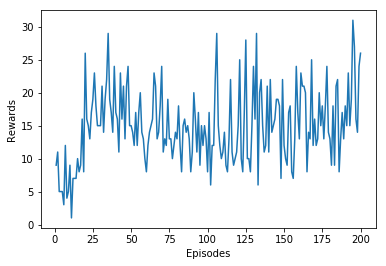

In [10]:
# Plotting
# print(Time_steps)
# print(Rewards)
plt.plot(Time_steps, Rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()